<a href="https://colab.research.google.com/github/zots0127/Colabs/blob/main/thickness_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!wget bojun.wang/history.zip
!mkdir data
!mv history.zip data/history.zip
%cd data
!unzip history.zip
!rm history.zip
%cd ..

URL transformed to HTTPS due to an HSTS policy
--2023-05-22 17:22:28--  https://bojun.wang/history.zip
Resolving bojun.wang (bojun.wang)... 193.123.234.57
Connecting to bojun.wang (bojun.wang)|193.123.234.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20737041 (20M) [application/zip]
Saving to: ‘history.zip’

history.zip         100%[===================>]  19.78M  7.96MB/s    in 2.5s    

2023-05-22 17:22:31 (7.96 MB/s) - ‘history.zip’ saved [20737041/20737041]

/content/data
Archive:  history.zip
 extracting: R151.3_G150.4_B115.6_98.png  
 extracting: R153.0_G150.4_B112.7_98.png  
 extracting: R153.3_G150.5_B110.7_98.png  
 extracting: R153.4_G144.3_B105.0_107.png  
 extracting: R155.1_G144.4_B104.6_107.png  
 extracting: R159.4_G154.7_B111.2_100.png  
 extracting: R159.9_G157.0_B115.8_100.png  
 extracting: R160.3_G156.3_B113.7_100.png  
 extracting: R162.9_G153.5_B113.6_111.png  
 extracting: R164.8_G158.5_B118.8_105.png  
 extracting: R166.2_G158.9_B11

In [48]:
import os
import re
import torch
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


class SolarCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGBA")
        image = Image.fromarray(np.array(image)[:, :, :3], mode="RGB")
        label = float(re.findall(r"_([\d.]+).png", self.image_files[idx])[0])
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
dataset = SolarCellDataset(root_dir="data", transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 256)  # Second fully connected layer
        self.fc3 = nn.Linear(256, 128)  # Third fully connected layer
        self.fc4 = nn.Linear(128, 1)  # Output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Activation for the first fully connected layer
        x = F.relu(self.fc2(x))  # Activation for the second fully connected layer
        x = F.relu(self.fc3(x))  # Activation for the third fully connected layer
        x = self.fc4(x)  # No activation on the output layer
        return x

model = ConvNet()




# Check for CUDA availability and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
def combined_loss(outputs, labels):
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    loss1 = mse_loss(outputs, labels)
    loss2 = l1_loss(outputs, labels)
    return 0.8 * loss1 + 0.2 * loss2

l1_loss = nn.L1Loss()
# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.95)

# Use TensorBoard
writer = SummaryWriter()

# Train the model
num_epochs = 1000
best_loss = np.inf  # initialize best loss as infinity

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # Move inputs and labels to GPU
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = l1_loss(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {loss.item()}")
    writer.add_scalar("Loss/train", running_loss, epoch)
    scheduler.step()

    # Evaluate the model
    model.eval()  # set model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device) # Move images and labels to GPU
            outputs = model(images)
            loss = l1_loss(outputs.view(-1), labels)
            test_loss += loss.item()

    writer.add_scalar("Loss/test", test_loss, epoch)

    # Save the model if it's the best one so far
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "solar_cell_thickness_model_best.pth")

writer.close()



Epoch: 1, Batch: 1, Loss: 106.83875274658203
Epoch: 1, Batch: 2, Loss: 104.11595153808594
Epoch: 1, Batch: 3, Loss: 90.9769287109375
Epoch: 1, Batch: 4, Loss: 74.59889221191406
Epoch: 2, Batch: 1, Loss: 46.60735321044922
Epoch: 2, Batch: 2, Loss: 10.736242294311523
Epoch: 2, Batch: 3, Loss: 52.65912628173828
Epoch: 2, Batch: 4, Loss: 61.48910903930664
Epoch: 3, Batch: 1, Loss: 46.05756378173828
Epoch: 3, Batch: 2, Loss: 19.65018653869629
Epoch: 3, Batch: 3, Loss: 11.469889640808105
Epoch: 3, Batch: 4, Loss: 28.18485450744629
Epoch: 4, Batch: 1, Loss: 34.117183685302734
Epoch: 4, Batch: 2, Loss: 34.74111557006836
Epoch: 4, Batch: 3, Loss: 30.919403076171875
Epoch: 4, Batch: 4, Loss: 19.63960075378418


KeyboardInterrupt: ignored

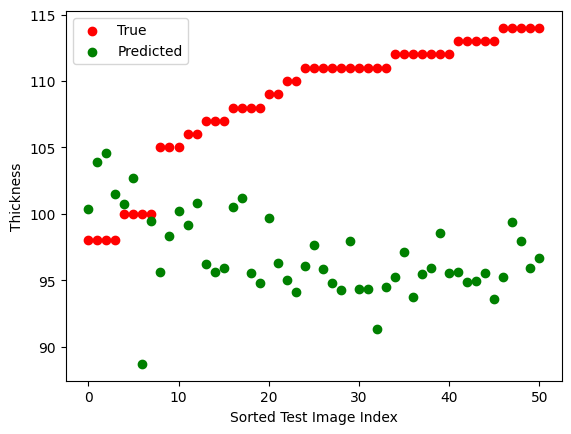

In [50]:
import os
import torch
import numpy as np
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict

# Create a results directory if it doesn't exist
if not os.path.exists("results"):
    os.makedirs("results")

# Define the image transformation
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Initialize lists to store true and predicted thickness values
true_thicknesses = []
predicted_thicknesses = []

# Initialize a dictionary to store the closest true thicknesses for each predicted thickness
closest_true_thicknesses = defaultdict(list)

# Sort the test dataset by true thickness
sorted_test_dataset = sorted(test_dataset, key=lambda x: x[1])

# Iterate through the sorted test dataset
for i, data in enumerate(sorted_test_dataset, 0):
    image, true_thickness = data
    image = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

    # Predict the thickness using the model
    input_image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_thickness = model(input_image).item()

    # Append the true and predicted thickness values to the lists
    true_thicknesses.append(true_thickness)
    predicted_thicknesses.append(predicted_thickness)

    # Calculate the absolute difference between the predicted and true thickness
    diff = abs(predicted_thickness - true_thickness)

    # Add the new difference and true thickness to the list
    closest_true_thicknesses[predicted_thickness].append((diff, true_thickness))

    # Sort the list by difference (ascending) and keep only the three smallest differences
    closest_true_thicknesses[predicted_thickness].sort(key=lambda x: x[0])
    closest_true_thicknesses[predicted_thickness] = closest_true_thicknesses[predicted_thickness][:3]

# Plot the true and predicted thickness values as a scatter plot
plt.scatter(range(len(true_thicknesses)), true_thicknesses, color='red', label='True')
plt.scatter(range(len(predicted_thicknesses)), predicted_thicknesses, color='green', label='Predicted')
plt.xlabel('Sorted Test Image Index')
plt.ylabel('Thickness')
plt.legend()
plt.show()


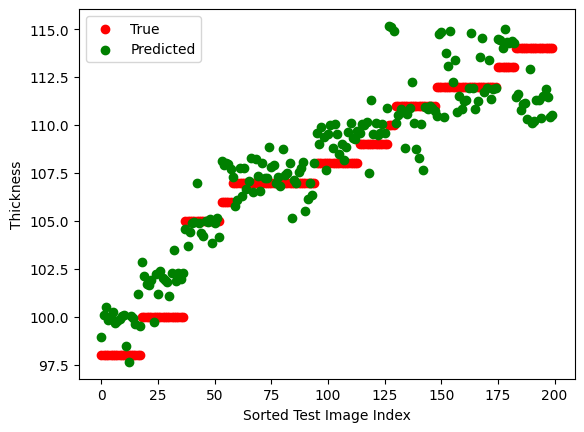

In [14]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt


# Create a results directory if it doesn't exist
if not os.path.exists("results"):
    os.makedirs("results")

# Define the image transformation
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Initialize lists to store true and predicted thickness values
true_thicknesses = []
predicted_thicknesses = []

# Sort the test dataset by true thickness
sorted_test_dataset = sorted(train_dataset, key=lambda x: x[1])

# Iterate through the sorted test dataset
for i, data in enumerate(sorted_test_dataset, 0):
    image, true_thickness = data
    image = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

    # Predict the thickness using the model
    input_image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_thickness = model(input_image).item()

    # Append the true and predicted thickness values to the lists
    true_thicknesses.append(true_thickness)
    predicted_thicknesses.append(predicted_thickness)

# Plot the true and predicted thickness values as a scatter plot
plt.scatter(range(len(true_thicknesses)), true_thicknesses, color='red', label='True')
plt.scatter(range(len(predicted_thicknesses)), predicted_thicknesses, color='green', label='Predicted')
plt.xlabel('Sorted Test Image Index')
plt.ylabel('Thickness')
plt.legend()
plt.show()


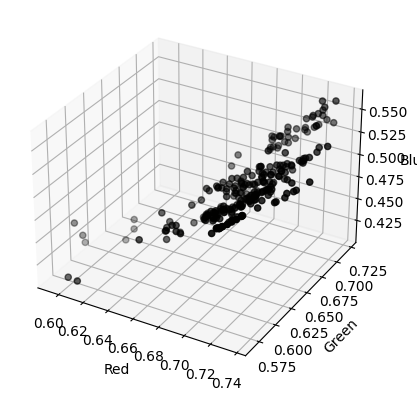

In [ ]:
import os
import re
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

# Custom dataset
class SolarCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGBA")
        image = Image.fromarray(np.array(image)[:, :, :3], mode="RGB")
        label = float(re.findall(r"_([\d.]+).png", self.image_files[idx])[0])
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
dataset = SolarCellDataset(root_dir="data", transform=transform)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Initialize empty list to hold RGB values
rgb_values = []

# Calculate average RGB values for each image in the dataset
for image, label in dataset:
    # Convert tensor to numpy array and compute mean RGB values
    numpy_image = image.numpy()
    mean_rgb = np.mean(numpy_image, axis=(1, 2))
    rgb_values.append(mean_rgb)

# Convert list to numpy array
rgb_values = np.array(rgb_values)

# Plot 3D graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rgb_values[:, 0], rgb_values[:, 1], rgb_values[:, 2], c=rgb_values / 255.0)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()


In [ ]:
import plotly.graph_objects as go

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=rgb_values[:, 0],
    y=rgb_values[:, 1],
    z=rgb_values[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=rgb_values,  # set color to RGB values
        colorscale='Viridis',  # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='Red',
    yaxis_title='Green',
    zaxis_title='Blue'))

# Save as HTML
fig.write_html("thickness.html")